In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
import pandas as pd
drive.mount('/content/drive',force_remount = True)

%cd /content/drive/MyDrive/speech_recognition/dataset_new
!ls


Mounted at /content/drive
/content/drive/MyDrive/speech_recognition/dataset_new
Native	Nonnative


In [2]:
pip install pydub

In [3]:
from pydub import AudioSegment
%cd /content/drive/MyDrive/speech_recognition/dataset_new/Native
import glob
for file in glob.glob("*.wav"):    # only loops over XML documents
        stereo_audio = AudioSegment.from_file(file, format="wav")
        mono_audios = stereo_audio.split_to_mono()

        mono_left = mono_audios[0].export(file, format="wav")
%cd /content/drive/MyDrive/speech_recognition/dataset_new/Nonnative
import glob
for file in glob.glob("*.wav"):    # only loops over XML documents
        stereo_audio = AudioSegment.from_file(file, format="wav")
        mono_audios = stereo_audio.split_to_mono()

        mono_left = mono_audios[0].export(file, format="wav")



/content/drive/MyDrive/speech_recognition/dataset_new/Native
/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative


In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
from random import seed
seed(42)
DATASET_PATH= "/content/drive/MyDrive/speech_recognition/dataset_new"
data_dir = pathlib.Path(DATASET_PATH)
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir))))
print('Example file tensor:', filenames[0])

Number of total examples: 200
Number of examples per label: 2
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/ttsMP3.com_VoiceText_2022-5-1_12_53_5.wav', shape=(), dtype=string)


In [6]:
train_files = filenames[:160]
val_files = filenames[160: 160 + 20]
test_files = filenames[-20:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 160
Validation set size 20
Test set size 20


In [7]:
test_file = tf.io.read_file(DATASET_PATH+'/Native/01877f20-c970-11ec-9771-cf523e8064a4.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([17856, 1])

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [9]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

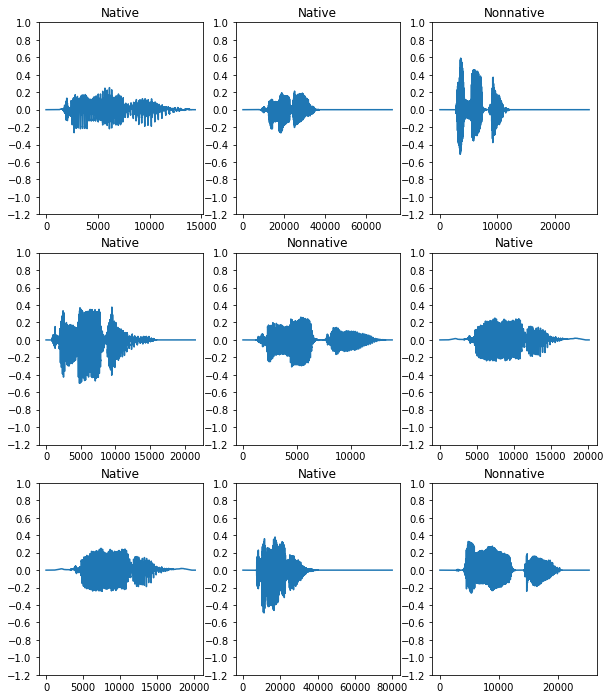

In [12]:

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [13]:

def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Native
Waveform shape: (14400,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

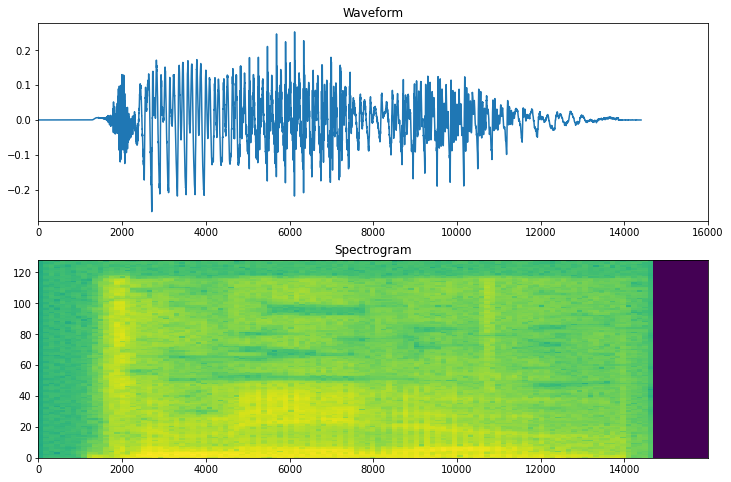

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [17]:
commands = ['Native', 'Nonnative']

In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

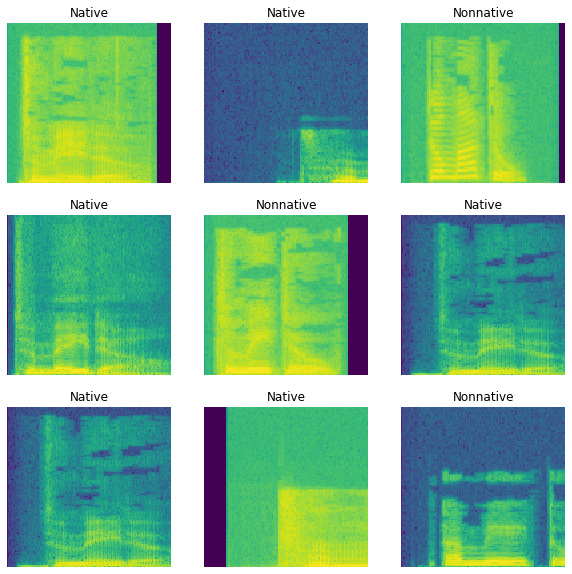

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds,files

In [22]:
train_ds = spectrogram_ds
val_ds,filepath= preprocess_dataset(val_files)
test_ds,filepath1 = preprocess_dataset(test_files)
print(filepath1)

tf.Tensor(
[b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/tomato (2).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/ttsMP3.com_VoiceText_2022-5-1_12_52_59.wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/preview (17).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/Text-to-Speech_01-May-2022_13-31 (2).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/fd0f3d70-c96f-11ec-88f8-57ded1ff6f6b.wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/22435232861_(IndiaDict.com).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/tomato (1).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/5d4607b2-262d-4452-b0df-b399f2473bad.wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/tomato (30).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_new/Native/tomato (13).wav'
 b'/content/drive/MyDrive/speech_recognition/dataset_

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
3/3 [==============================] - 2s 392ms/step - loss: 0.5961 - accuracy: 0.6750 - val_loss: 0.3416 - val_accuracy: 0.9500
Epoch 2/10
3/3 [==============================] - 1s 204ms/step - loss: 0.3878 - accuracy: 0.8562 - val_loss: 0.2353 - val_accuracy: 0.9000
Epoch 3/10
3/3 [==============================] - 1s 206ms/step - loss: 0.2955 - accuracy: 0.9062 - val_loss: 0.1740 - val_accuracy: 0.9500
Epoch 4/10
3/3 [==============================] - 1s 198ms/step - loss: 0.2185 - accuracy: 0.9062 - val_loss: 0.1671 - val_accuracy: 0.9000
Epoch 5/10
3/3 [==============================] - 1s 206ms/step - loss: 0.1570 - accuracy: 0.9312 - val_loss: 0.1621 - val_accuracy: 0.9000
Epoch 6/10
3/3 [==============================] - 1s 215ms/step - loss: 0.1266 - accuracy: 0.9625 - val_loss: 0.1232 - val_accuracy: 0.9500
Epoch 7/10
3/3 [==============================] - 1s 206ms/step - loss: 0.1042 - accuracy: 0.9563 - val_loss: 0.1081 - val_accuracy: 0.9500
Epoch 8/10
3/3 [====

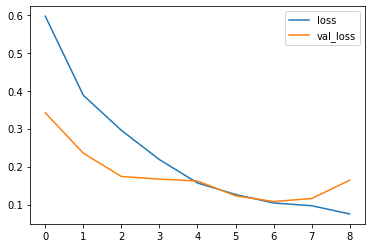

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [29]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
# for i in test_labels:
#    if i == 1: 
#      print(filepath1[i])



In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
non_native_speaker_list = []
for i in range(len(y_pred)):
  if y_pred[i] == y_true[i] and y_pred[i] == 1:
     tensorpath = filepath1[i]
     b_file = tf.keras.backend.get_value(tensorpath)
     b_removed = b_file.decode("utf-8")
     b_moved_list = [b_removed]
     non_native_speaker_list.append(b_moved_list)
test_acc = sum(y_pred == y_true) / len(y_true)

print(f'Test set accuracy: {test_acc:.0%}')
print(non_native_speaker_list)

Test set accuracy: 85%
[['/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/preview (17).wav'], ['/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/22435232861_(IndiaDict.com).wav'], ['/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/tomato (1).wav'], ['/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/preview (24).wav']]


In [31]:
%cd /content/drive/MyDrive/speech_recognition/
import csv
import glob, os

#columns = ['name', 'class', 'pronunciation']
rows = non_native_speaker_list
with open('non_native_file.csv', 'w') as csvfile: 
    csvwriter = csv.writer(csvfile)  
    #csvwriter.writerow(columns) 
    csvwriter.writerows(rows)
     


/content/drive/MyDrive/speech_recognition


In [32]:
!ls

assignment2   dataset_old_working  speech_recongnition_cnn.ipynb
dataset       loader.py		   speech_recongnition_cnn_working.ipynb
dataset1.csv  model.py		   ttsMP3.com_VoiceText_2022-5-2_18_17_32.wav
dataset_new   non_native_file.csv


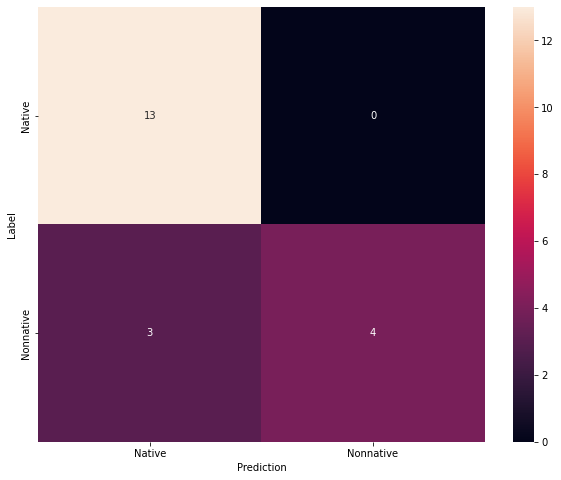

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [34]:
import glob
sample_file = '/content/drive/MyDrive/speech_recognition/french.wav'
#sample_file = '/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/1651413215839-voicemaker.in-speech.wav'
stereo_audio = AudioSegment.from_file(sample_file, format="wav")

#/content/drive/MyDrive/speech_recognition/dataset_new/Nonnative/147YmrqsGfc4012a6145c97ca56957631e91175b0oyheEZWjM.wav
mono_audios = stereo_audio.split_to_mono()

mono_left = mono_audios[0].export(sample_file, format="wav")

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

FileNotFoundError: ignored